# Predict time series over horizon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_percentage_error)

### Get data

In [2]:
# Lorenz ts
def lorenz_ts(N=None):
    x = np.array([])
    i = 0
    with open("lorenz.txt") as f:
        for line in f:
            x = np.append(x, float(line))
            i += 1
            if N is not None and i == N:
                break
    return x


lorenz = lorenz_ts()

### Implement predictive clustering model

In [3]:
from sklearn.base import BaseEstimator
from sklearn.cluster import DBSCAN
from typing import Tuple
from wishart import Wishart
from scipy import stats

import itertools
from tqdm import tqdm


class PredictiveClustering(BaseEstimator):
    def __init__(self, K: int, L: int, clustering: BaseEstimator = None,
                 distance_metric=None, choose_prediction: str = 'mode',
                 eps: float = 5e-3, unpredicted_ratio: float = 3,
                 verbose: int = None) -> None:
        """
            Parameters
            ----------
            K : int
                Range of values in pattern, mean length between observation
                in time series.
            L : int
                Length of patterns.
            clustering : sklearn.BaseEstimator
                Witch clustering algorithm use. Default without clustering. 
                For now support only Wishart clustering algorithm.
            distance_metric: Callable[[x: np.array, y: np.array], float]
                Metric for calculating distances between motives.
                Default is Euclidean norm.
            choose_prediction: str
                Method for choosing single prediction. Default is mode.
            eps: float
                Acceptable distance between motives for prediction.
            unpredicted_ratio: float
                Ratio between two largest clusters for marking point 
                not predictable. Only used when clustering approach used for 
                choosing single prediction. Default value is 3.
            verbose : int
                Control how verbose logging should be. Default without logging.
        """
        self.K = K
        self.L = L
        self.clustering = clustering
        self.distance_metric = distance_metric
        if distance_metric is None:
            self.distance_metric = (
                lambda x, y: np.linalg.norm(x-y, axis=1)
            )
        self.choose_prediction = choose_prediction
        self.eps = eps
        self.unpredicted_ratio = unpredicted_ratio
        self.verbose = verbose

        self.generate_patterns()

    def generate_patterns(self) -> None:
        patterns = itertools.product(np.arange(1, self.K+1), repeat=self.L)
        self.patterns = np.array(list(patterns))

    def transform(self, X: np.array, pattern: np.array) -> np.array:
        N = len(X)
        indexes = np.array([0, *np.cumsum(pattern)])
        return_n = N-indexes[-1]
        index_n = len(indexes)
        indexes = np.repeat(indexes.reshape(1, index_n), return_n, axis=0)
        indexes += np.repeat(np.arange(return_n),
                             index_n).reshape((return_n, index_n))
        return X[indexes]

    def generate_motives(self, X: np.array) -> None:
        iter_throw = (self.patterns 
                      if self.verbose is None else tqdm(self.patterns))
        if self.clustering is None:
            self.motives = []
            for pattern in iter_throw:
                self.motives.append(self.transform(X, pattern))
            return

        self.motives = []
        for pattern in iter_throw:
            samples = self.transform(X, pattern)
            self.clustering.fit(samples)
            centers = None

            if type(self.clustering) is Wishart:
                cluster_object = self.clustering.clusters_to_objects
                for label in range(len(cluster_object)):
                    cluster_elements = samples[cluster_object[label]]

                    if label == 0 or len(cluster_elements) == 0:
                        continue

                    center = np.mean(cluster_elements, axis=0)
                    centers = (np.vstack((centers, center))
                               if centers is not None else center)

                self.motives.append(centers)
            else:
                raise NotImplementedError(
                    f"For now we don't support clustering by {type(self.clustering)}")

    def predict_set(self, X: np.array) -> Tuple[np.array, np.array]:
        predictions = []
        distances = []

        for i in range(len(self.patterns)):
            pattern = -np.cumsum(self.patterns[i][::-1])[::-1]
            new_motive = X[pattern]

            current_distances =  self.distance_metric(
                new_motive, self.motives[i][:, :-1])
            current_predictions = self.motives[i][:,-1][current_distances < self.eps]
            current_distances = current_distances[current_distances < self.eps]

            distances.extend(current_distances)
            predictions.extend(current_predictions)
        
        return np.array(predictions), np.array(distances)
    
    def choose_single_prediction(self, predictions, distances):
        if len(predictions) == 0:
            return np.nan

        match self.choose_prediction:
            case "mode":
                return stats.mode(predictions, keepdims=True)[0]
            case "mean":
                return np.mean(predictions)
            case "wmean":
                weights = distances / distances.sum()
                return np.mean(weights*predictions)
            case BaseEstimator():
                self.choose_prediction.fit(predictions.reshape(-1, 1))
                labels = self.choose_prediction.labels_
                u_labels, counts = np.unique(labels[labels > -1], return_counts=True)

                max_clusters = np.sort(counts)[-2:]
                if (u_labels.size > 1 and 
                    max_clusters[1] / max_clusters[0] < self.unpredicted_ratio):
                    return np.nan
                
                if u_labels.size > 0:
                    return predictions[labels == u_labels[counts.argmax()]].mean()
    
    def fit(self, X: np.array, y: np.array = None) -> BaseEstimator:
        self.generate_motives(X)
        return self
    
    def predict(self, X: np.array, prediction_range: int = 1) -> np.array:
        predicted_points = np.array([])
        iter_throw = (tqdm(range(prediction_range)) 
                      if self.verbose else range(prediction_range))
        for _ in iter_throw:
            predictions, distances = self.predict_set(np.append(X, predicted_points))
            prediction = self.choose_single_prediction(predictions, distances)
            predicted_points = np.append(predicted_points, prediction)
        return predicted_points
            

### Test model on lorenz time series

In [4]:
x_train, x_test = lorenz[:10001], lorenz[10001:10601]
x_train.shape, x_test.shape

((10001,), (600,))

In [5]:
def mae(y_true, y_pred, decimals=4):
    return np.around(
        np.nanmean(np.abs(y_true - y_pred)),
        decimals
    )

#### DBSCAN

In [6]:
clust_predictions = DBSCAN(eps=0.01, min_samples=5)
model = PredictiveClustering(10, 4, 
                             verbose=1,
                             choose_prediction=clust_predictions)
model.fit(x_train)
predictions = model.predict(x_train, prediction_range=100)

100%|██████████| 100/100 [12:26<00:00,  7.46s/it]


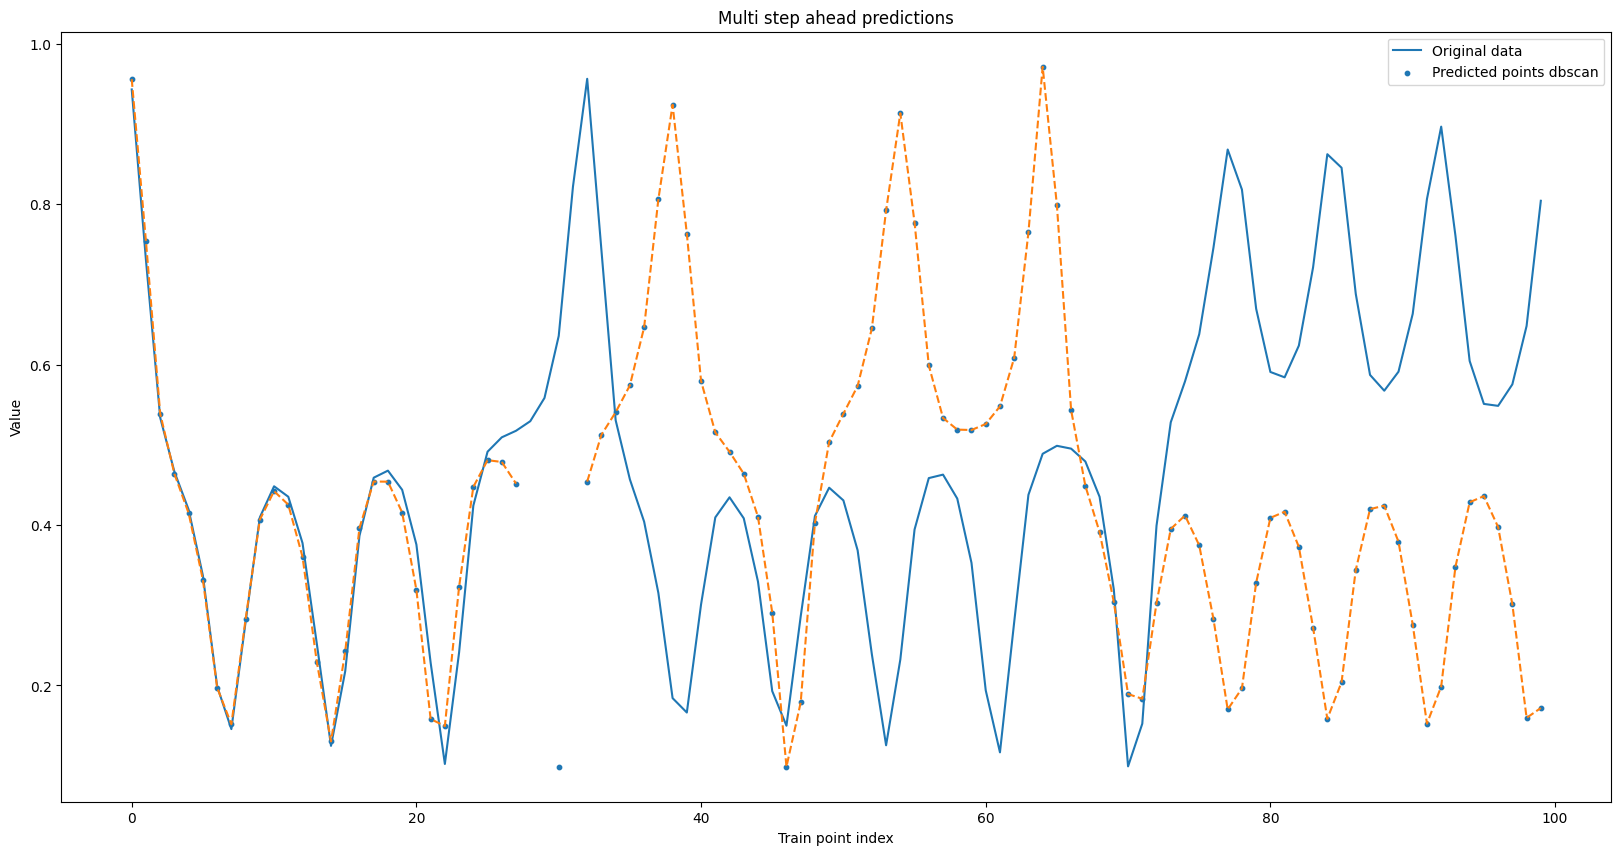

In [7]:
plt.figure(figsize=(20, 10))

plt.plot(x_test[:100], label="Original data")

plt.scatter(range(len(predictions)), predictions, s=10, label="Predicted points dbscan")
plt.plot(predictions, ls='--')

ax = plt.gca()
ax.set_xlabel('Train point index')
ax.set_ylabel('Value')
ax.set_title("Multi step ahead predictions")

plt.legend()
plt.show()

In [8]:
print(f"Prediction with DBSCAN, 100 points, MAE: {mae(x_test[:100], predictions[:100])}")
print(f"Prediction with DBSCAN, 50 points, MAE: {mae(x_test[:50], predictions[:50])}")
print(f"Prediction with DBSCAN, 20 points, MAE: {mae(x_test[:20], predictions[:20])}")

Prediction with DBSCAN, 100 points, MAE: 0.2101
Prediction with DBSCAN, 50 points, MAE: 0.1056
Prediction with DBSCAN, 20 points, MAE: 0.0105


#### Mean

In [9]:
model = PredictiveClustering(10, 4, verbose=1, choose_prediction="mean")
model.fit(x_train)
predictions = model.predict(x_train, prediction_range=100)

100%|██████████| 100/100 [05:22<00:00,  3.23s/it]


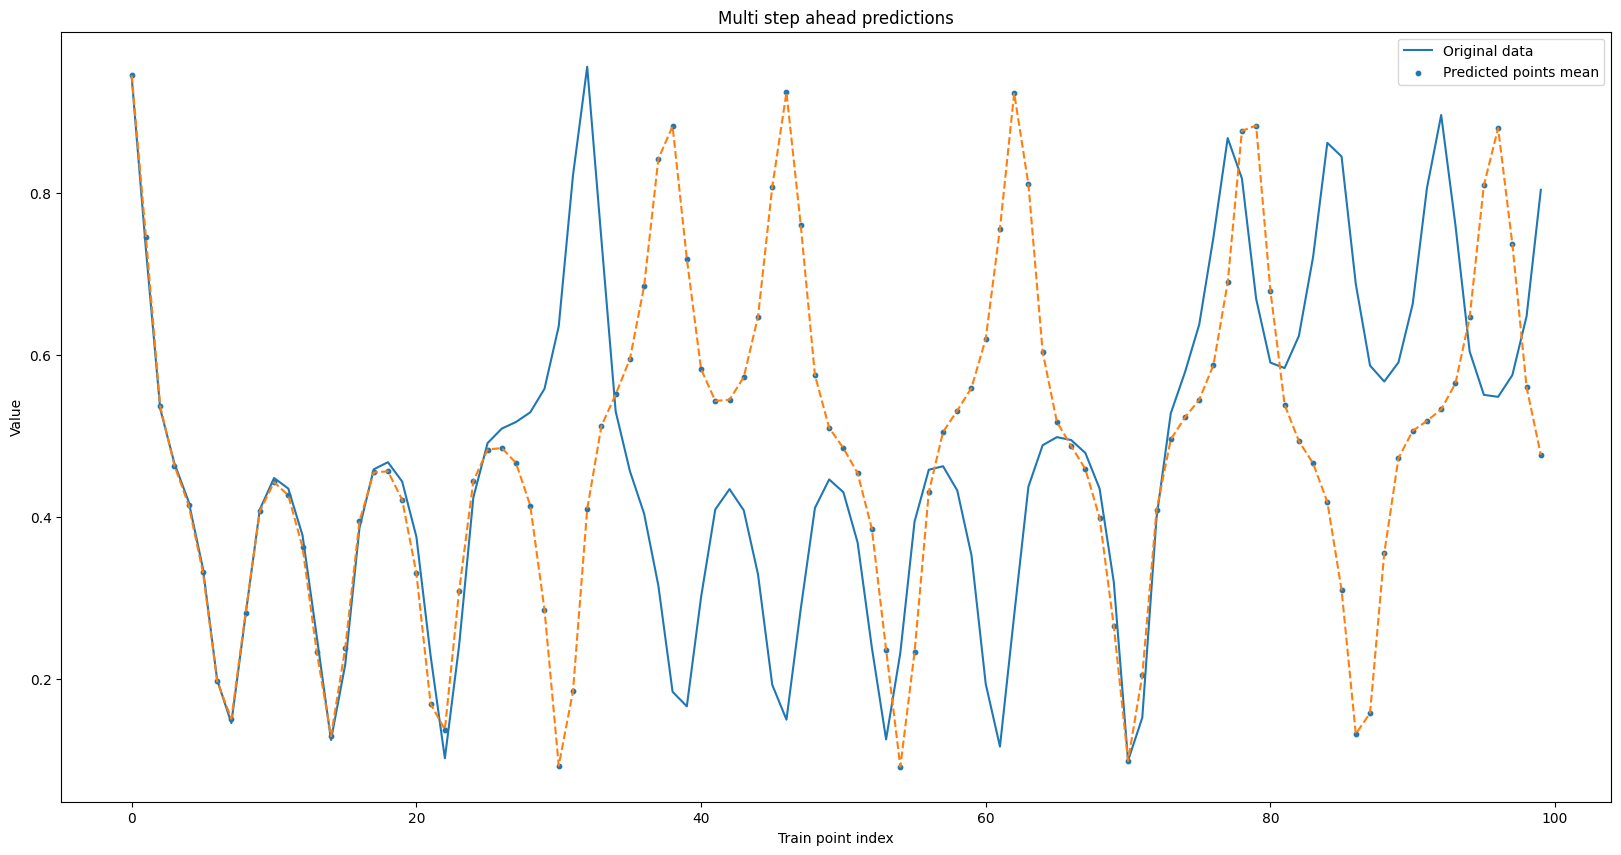

In [10]:
plt.figure(figsize=(20, 10))

plt.plot(x_test[:100], label="Original data")

plt.scatter(range(len(predictions)), predictions, s=10, label="Predicted points mean")
plt.plot(predictions, ls='--')

ax = plt.gca()
ax.set_xlabel('Train point index')
ax.set_ylabel('Value')
ax.set_title("Multi step ahead predictions")

plt.legend()
plt.show()

In [11]:
print(f"Prediction with mean, 100 points, MAE: {mae(x_test[:100], predictions[:100])}")
print(f"Prediction with mean, 50 points, MAE: {mae(x_test[:50], predictions[:50])}")
print(f"Prediction with mean, 20 points, MAE: {mae(x_test[:20], predictions[:20])}")

Prediction with mean, 100 points, MAE: 0.1743
Prediction with mean, 50 points, MAE: 0.1628
Prediction with mean, 20 points, MAE: 0.0082


#### Mode

In [17]:
model = PredictiveClustering(10, 4, verbose=1)
model.fit(x_train)
predictions = model.predict(x_train, prediction_range=100)

100%|██████████| 100/100 [05:26<00:00,  3.26s/it]


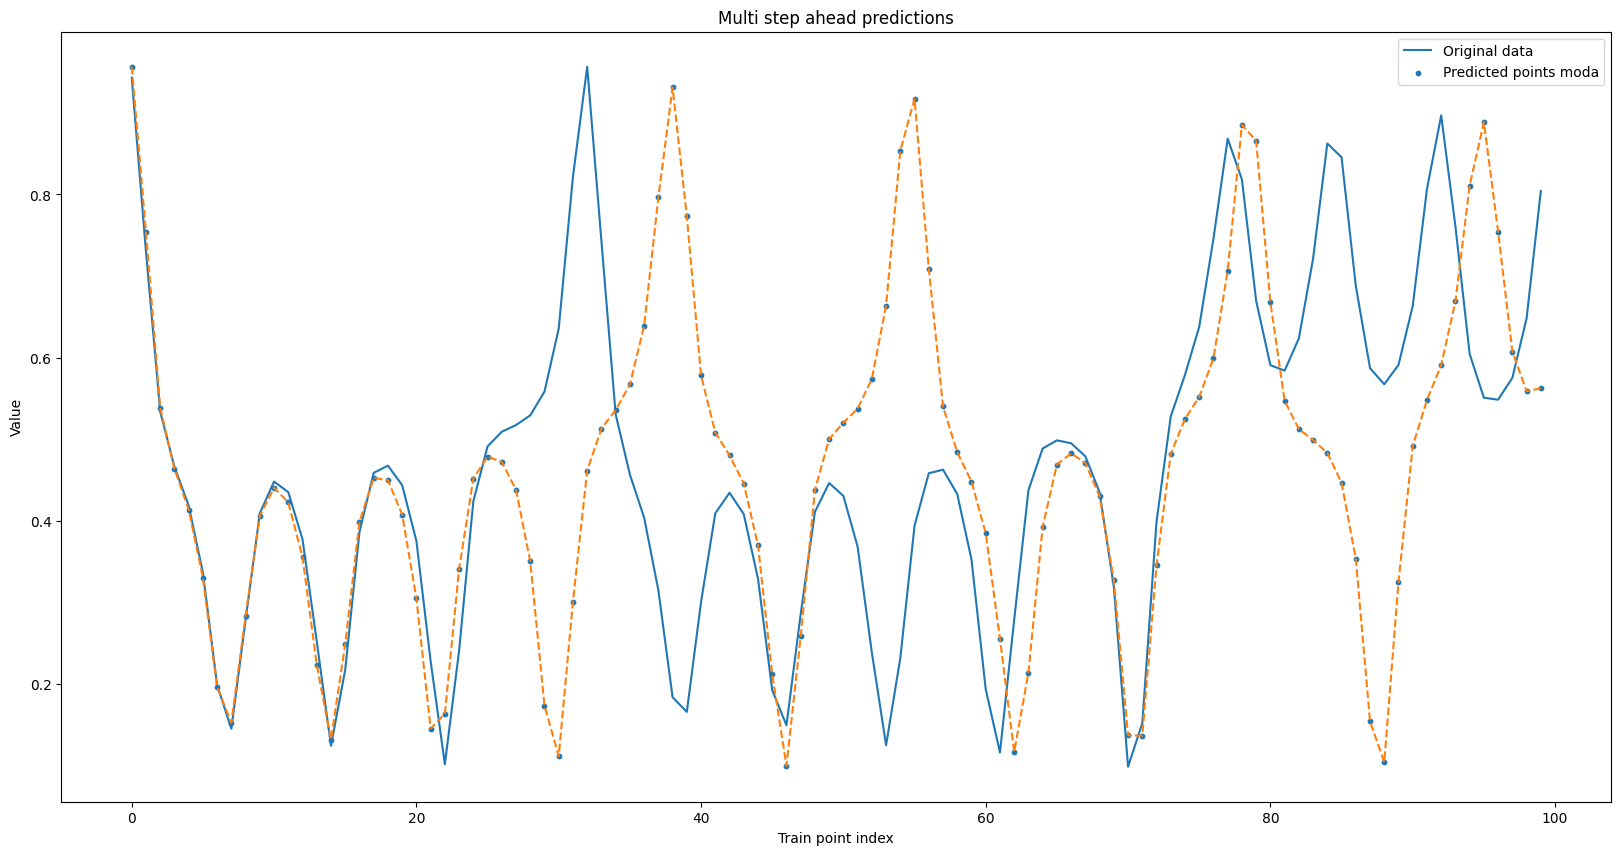

In [18]:
plt.figure(figsize=(20, 10))

plt.plot(x_test[:100], label="Original data")

plt.scatter(range(len(predictions)), predictions, s=10, label="Predicted points moda")
plt.plot(predictions, ls='--')

ax = plt.gca()
ax.set_xlabel('Train point index')
ax.set_ylabel('Value')
ax.set_title("Multi step ahead predictions")

plt.legend()
plt.show()

In [19]:
print(f"Prediction with moda, 100 points, MAE: {mae(x_test[:100], predictions[:100])}")
print(f"Prediction with moda, 50 points, MAE: {mae(x_test[:50], predictions[:50])}")
print(f"Prediction with moda, 20 points, MAE: {mae(x_test[:20], predictions[:20])}")

Prediction with moda, 100 points, MAE: 0.1507
Prediction with moda, 50 points, MAE: 0.1184
Prediction with moda, 20 points, MAE: 0.0128
